In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import struct

# Rozsireni pro praci s float s vyuzitim binarniho jedince

In [2]:
REPRESENTATION_TYPE_DEFAULT = 'default'
REPRESENTATION_TYPE_IEEE754 = 'IEEE754'
REPRESENTATION_TYPE_FIXED_POINT = 'FIXED_POINT'
REPRESENTATION_TYPE_BCD = 'BCD'

class BinRepresentation:
    @staticmethod
    def real_to_binary_ieee754(number: float) -> list:
        binary = format(struct.unpack(
            'I', struct.pack('f', number))[0], '032b')
        binary_list = [int(bit) for bit in binary]
        return binary_list

    @staticmethod
    def binary_to_real_ieee754(binary: list) -> float:
        binary_str = ''.join(str(bit) for bit in binary)
        integer_value = int(binary_str, 2)
        real_value = struct.unpack('f', struct.pack('I', integer_value))[0]
        return float(real_value)

    @staticmethod
    def real_to_binary_fixed_point(number: float) -> list:
        sign_bit = 1 if number < 0 else 0
        number = abs(number)
        int_part = int(number)
        frac_part = int((number - int_part) * (2 ** 16))
        int_bin = format(int_part, '015b')  # 15 bitů pro celou část
        frac_bin = format(frac_part, '017b')  # 17 bitů pro desetinnou část
        bit_list = [int(sign_bit)] + [int(bit) for bit in int_bin] + [int(bit) for bit in frac_bin]
        return bit_list

    @staticmethod
    def binary_to_real_fixed_point(binary: list) -> float:
        sign = -1 if binary[0] else 1  # Znaménko: 1 pro záporné, 0 pro kladné číslo
        int_part = int(''.join(str(bit) for bit in binary[1:16]), 2)
        frac_part = int(''.join(str(bit) for bit in binary[16:]), 2) / (2 ** 16)
        return sign * (int_part + frac_part)

    @staticmethod
    def real_to_binary_bcd(number: float) -> list:
        binary = []
        # cislice v bcd 
        int_part = int(abs(number))
        decimal_part = (abs(number) - int_part) * 1e5
        total = int(int_part * 1e5 + decimal_part)
        for _ in range(8):
            digit = total % 10
            for bit in reversed(format(int(digit), '04b')):
                binary.append(int(bit))
            total //= 10
        binary.reverse()
        # znameko cisla
        binary[0] = int(number > 0)
        return binary

    @staticmethod
    def binary_to_real_bcd(bcd_list):
        bcd_digits = [bcd_list[i:i + 4] for i in range(0, len(bcd_list), 4)]
        bcd_digits[0] = bcd_digits[0][1:]
        # cislice v bcd 
        result = 0
        for digit in bcd_digits:
            digit_str = ''.join(str(bit) for bit in digit)
            result = result * 10 + int(digit_str, 2)
        # znameko cisla
        if bcd_list[0] == 0:
            result *= -1    
        return float(result / 1e5)

# Definice tridy jedince populace

In [3]:
class BinIndividual:
    def __init__(self, representation_type: str, chromosome: list, fitness_function):
        """
        Vytvori jedince populace

        Parametry:
            representation_type - typ reprezentace chromozomu
            chromosome - chromozom jedince (v tomto pripade binarni retezec)  
            fitness_function - reference na ucelovou funkci pro hodnoceni kvality jedince
        """
        self.fitness_function = fitness_function
        self.fitness = 0

        self.representation_type = representation_type
        self.chromosome = chromosome
        self.bounds = None

    def set_bounds(self, bounds: list):
        """
        Nastaveni mezi chromozomu
        """
        self.bounds = bounds

    def get_representation_type(self):
        """
        Navrati typ reprezentace chromozomu (jeho format)
        """
        return self.representation_type

    def get_chromosome(self):
        """
        Navrati chromozom jedince
        """
        return self.chromosome

    def get_fitness(self):
        """
        Navrati hodnotu kvality uzivatele
        """
        return self.fitness

    def set_chromosome_value(self, value):
        """
        Nastavi hodnotu chromozomu (pokud ma jedinec zvolenou nejakou
        reprezentaci, je binarni chromozom vypocitan podle transformacni 
        funkce dane reprezentace binarniho chromozomu)
        """
        if self.representation_type == REPRESENTATION_TYPE_IEEE754:
            self.chromosome = BinRepresentation.real_to_binary_ieee754(value)
        elif self.representation_type == REPRESENTATION_TYPE_FIXED_POINT:
            self.chromosome = BinRepresentation.real_to_binary_fixed_point(value)
        elif self.representation_type == REPRESENTATION_TYPE_BCD:
            self.chromosome = BinRepresentation.real_to_binary_bcd(value)
        else:
            self.chromosome = value

    def get_value_of_chromosome(self):
        """
        Navrati hodnotu chromozomu po aplikaci prevodni trasformace (puvodni binarni 
        chromozom bude navracen jen v pripade ze zvoleny typ reprezentace je 'default')
        """
        x_value = 0
        if self.representation_type == REPRESENTATION_TYPE_IEEE754:
            x_value = BinRepresentation.binary_to_real_ieee754(self.chromosome)
        elif self.representation_type == REPRESENTATION_TYPE_FIXED_POINT:
            x_value = BinRepresentation.binary_to_real_fixed_point(
                self.chromosome)
        elif self.representation_type == REPRESENTATION_TYPE_BCD:
            x_value = BinRepresentation.binary_to_real_bcd(self.chromosome)
        else:
            x_value = self.chromosome
        return x_value

    def evaluate_fitness(self):
        """
        Ohodnoti kvalitu jedince (podte typu reprezentace chromozomu)
        """
        x_value = self.get_value_of_chromosome()
        self.fitness = self.fitness_function(x_value)
        self.check_bounds()
    
    def check_bounds(self):
        """
        Overi hranice chromozomu a podu je prekrocena tak ji nastavi na limitni hodnotu 
        (aktivni jen pokud nejde o 'default' reprezentaci)
        """
        x_value = self.get_value_of_chromosome()
        if self.representation_type != REPRESENTATION_TYPE_DEFAULT:
            if self.bounds is not None:
                if x_value < self.bounds[0]:
                    self.set_chromosome_value(self.bounds[0])
                    self.fitness = self.fitness_function(self.bounds[0])
                elif x_value > self.bounds[1]:
                    self.set_chromosome_value(self.bounds[1])
                    self.fitness = self.fitness_function(self.bounds[1])

    def mutate(self, probability: float):
        """
        Mutace, zmutuju chromozom jedince

        Paramtery:
            x - Pole bitu 0/1
            probability - Pravdepodobnost mutace jednoho bitu retezce
        """
        mutated = []
        for bit in self.chromosome:
            if random.random() < probability:
                mutated.append(1 - bit)
            else:
                mutated.append(bit)
        self.chromosome = mutated

    def crossover(self, other):
        """
        Jednobodove krizeni

        Paramtery:
            other - Reference na druheho rodice "jedince populace"

        Return: Potomek 1, Potomek 2
        """
        rep_type = other.get_representation_type()

        # reprezentace typy obou rodicu musi byt shodne (pripad ze by se neshodovali nenastave pokud jsou v populaci vsichni jedinci stejneho typu reprezentace)
        if rep_type != self.representation_type:
            return None

        point = random.randint(1, len(self.chromosome) - 1)
        chromosome1 = self.chromosome[:point] + other.get_chromosome()[point:]
        chromosome2 = other.get_chromosome()[:point] + self.chromosome[point:]

        child1 = BinIndividual(rep_type, chromosome1, self.fitness_function)
        child2 = BinIndividual(rep_type, chromosome2, self.fitness_function)
        child1.set_bounds(self.bounds)
        child2.set_bounds(self.bounds)
        return child1, child2

# Definice tridy populace

In [4]:
class BinPopulation:

    def __init__(self, individuals: list[BinIndividual]) -> None:
        """
        Vytvori populaci jedincu
        
        Paramtery:
            individuals - inicializacni list s jedinci populace
        """
        self.individuals = individuals
        pass

    def random_init(self, population_size: int, chromosome_lengths: int, fitness_function, representation_type: str = "default", bounds: list = [-1, 1]):
        """
        Nahodna inicializace populace

        Parametry:
            population_size - Velikost populace
            chromosome_lengths - Delka chromozomu jedince  
            fitness_function - Reference na ucelovou funkci hodnotici kvalitu jedincu v populaci
        """
        self.individuals.clear()

        for _ in range(population_size):

            # nahodne generovani hodnoty chromozomu
            chromosome = []
            if representation_type == 'ieee754':
                chromosome = BinRepresentation.real_to_binary_ieee754(random.uniform(bounds[0], bounds[1]))
            elif representation_type == 'fixed_point':
                chromosome = BinRepresentation.real_to_binary_fixed_point(random.uniform(bounds[0], bounds[1]))
            elif representation_type == 'bcd':
                chromosome = BinRepresentation.real_to_binary_bcd(random.uniform(bounds[0], bounds[1]))
            else:
                chromosome = [random.randint(0, 1) for _ in range(chromosome_lengths)]

            individual = BinIndividual(representation_type, chromosome, fitness_function)
            individual.set_bounds(bounds)
            self.individuals.append(individual)

    def add_individual(self, individual: BinIndividual):
        """
        Prida jedince do populace

        Paramtery:
            individual - Jedinec populace

        Return: 
        """
        self.individuals.append(individual)

    def select_roulette(self) -> BinIndividual:
        """
        Rulotova selekce

        Return: Vybrany potomek populace
        """
        total_fitness = sum(i.fitness for i in self.individuals)
        if total_fitness == 0:
            return None

        r = random.uniform(0, total_fitness)
        current_fitness = 0

        for i in self.individuals:
            current_fitness += i.get_fitness()
            if current_fitness >= r:
                return i
            
        return None

    def select_rank(self) -> BinIndividual:
        """
        Poradova selekce

        Return: Vybrany potomek populace
        """
        ranks = list(range(1, len(self.individuals) + 1))
        total_rank = sum(ranks)
        probabilities = [rank / total_rank for rank in ranks]
        selected_index = random.choices(
            range(len(self.individuals)), probabilities)[0]
        return self.individuals[selected_index]
    
    def evaluate_population(self):
        """
        Ohodnoti celou populaci jedincu
        """
        for i in self.individuals:
            i.evaluate_fitness()

    def calculate_stats(self) -> tuple([float, float, float, float, float]):
        """
        Vypocet statistickych udaju populace

        Return: min. hodnota fitness, max. hodnota fitness, prumer, median, smerodatna odchyka
        """
        self.evaluate_population()
        fitness_values = [i.get_fitness() for i in self.individuals]
        if not fitness_values:
            return None, None, None, None 
        
        fitness_values = np.array(fitness_values)
        min_fitness = min(fitness_values)
        max_fitness = max(fitness_values)
        mean_fitness = np.mean(fitness_values)
        median_fitness = np.median(fitness_values)
        std_deviation_fitness = np.std(fitness_values)

        return min_fitness, max_fitness, mean_fitness, median_fitness, std_deviation_fitness

# Trida implementujici chromosometicky algoritmus

In [5]:
class GeneticAlgorithm:
    def __init__(self, population: BinPopulation, elitism_ratio: float, selection_type: str, mutation_probability: float, num_generations: int):
        self.population = population
        self.elitism_ratio = elitism_ratio
        self.selection_type = selection_type
        self.mutation_probability = mutation_probability
        self.num_generations = num_generations

    def __select_individual(self):
        """
        Vyber jedince podle zvoleneho typu vyberu (roulette nebo rank)

        Return: Vybrany jedinec
        """
        if self.selection_type == 'roulette':
            return self.population.select_roulette()
        elif self.selection_type == 'rank':
            return self.population.select_rank()
        else:
            raise ValueError("Undefined selector type")

    def __evolve_population(self):
        """
        Vytvori novou generaci potomku a ta nahradi tu aktualni
        """
        new_population = list()

        elite_count = int(self.elitism_ratio * len(self.population.individuals))
        elites = sorted(self.population.individuals, key=lambda x: -x.get_fitness())[:elite_count]
        new_population.extend(elites)

        while len(new_population) < len(self.population.individuals):
            parent1 = self.__select_individual()
            parent2 = self.__select_individual()
            if parent1 is None or parent2 is None:
                continue
            child1, child2 = parent1.crossover(parent2)
            child1.mutate(self.mutation_probability)
            child2.mutate(self.mutation_probability)
            new_population.extend([child1, child2])

        for i in new_population:
            i.check_bounds()
            
        self.population.individuals = new_population

    def run(self) -> list[float]:
        """
        Spusti geneticky algoritmus

        Return: Prubeh hodnoty ucelove funkce nejlepsiho jedince v ramci vsech chromosomeraci
        """
        fitness_history = []
        for _ in range(self.num_generations):
            self.population.evaluate_population()
            # nejlepsi hodna fitness v populaci
            best_fitness = max(individual.get_fitness()
                               for individual in self.population.individuals)
            fitness_history.append(best_fitness)
            # vyvinuti populace
            self.__evolve_population()

        return fitness_history

# Ucelove funkce

In [6]:
def schwefel(x):
    return np.sum(-x * np.sin(np.sqrt(np.abs(x))))

def sphere(x):
    return -(np.sum(x**2))

def rosenbrock(x):
    return -(100 * (x - x**2)**2 + (x - 1)**2)

# Utility

In [7]:
def plot_convergence_graph(axs, fitness_history: list, graph_title: str, label: str):
    """
    Vykresli konvergencni graf
    """
    chromosomerations = list(range(len(fitness_history)))
    axs.plot(chromosomerations, fitness_history, label=label)
    axs.set_title(f'Convergence graph for {graph_title}')
    axs.set_xlabel('Generation')
    axs.set_ylabel('Fitness')
    axs.legend()
    axs.grid(True)

def print_results(axs, fitness_histories: list[list], stats_list: list[list], num_runs: int, representation_type: str, func_name: str):
    """
    Vypise stisticky zpracovany vysledek
    """
    average_fitness_history = [sum(e[i] for e in fitness_histories) / num_runs for i in range(len(fitness_histories[0]))]
    average_stats = [sum(stats[i] for stats in stats_list) / num_runs for i in range(len(stats_list[0]))]
    plot_convergence_graph(axs, average_fitness_history, representation_type, func_name)
    print("Func: %s [%s] ==> Worst: %f, Best: %f, Mean: %f, Median: %f, Std Dev: %f" % (func_name, representation_type, average_stats[0], average_stats[1], average_stats[2], average_stats[3], average_stats[4]))

# Nastaveni

In [8]:
# velikost populace
population_size = 100

# vyberu rodicu
selection_type = 'rank' # rank / roulette

# pravdepodobnost mutace
mutation_probability = 0.01

# delky chromozomu jedince v populaci (v tomto pripade delka binarniho retezce)
chromosome_length = 32

# pocet opakovani pro statisticke zpracovani
num_runs = 10

# Vytvoreni populaci + testovaciho programu

In [9]:
# Inicializace populace pro Schwefel funkci
schwefel_population = BinPopulation([])

# Inicializace populace pro Sphere funkci
sphere_population = BinPopulation([])

# Inicializace populace pro Rosenbrock funkci
rosenbrock_population = BinPopulation([])

In [10]:
def run_test(pop: BinPopulation, num_generations: int, func, func_name: str, bounds: list):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))

    ga = GeneticAlgorithm(pop, 0.1, selection_type, mutation_probability, num_generations)

    # spusteni genetickeho algoritmu (definovany pocet iteraci v nastaveni => pro statisticke zpracovani a ziskani prumerneho vysledku)
    # v jedno grafu zobrazi 3 grafy pro vsechny reprezentace float cisla v 32b binarni podobe
    for i, representation_type in enumerate([REPRESENTATION_TYPE_IEEE754, REPRESENTATION_TYPE_FIXED_POINT, REPRESENTATION_TYPE_BCD]):
        fitness_histories, stats_list = [], []
        for _ in range(num_runs):
            # nahodna inicializace/reinicializace populace
            pop.random_init(population_size, chromosome_length, func, representation_type, bounds)
            # spusteni genetickeho algoritmu
            fitness_histories.append(ga.run())
            # vypocet statistickych udaju finalni epochy populace 
            stats_list.append(pop.calculate_stats())

        # vypocet a zobrazeni zprumerovanych vysledku (konvergencni graf + statistika finalni epochy populace)
        print_results(axs[i], fitness_histories, stats_list, num_runs, representation_type, func_name)

    plt.tight_layout()
    plt.show()

# Schwefel

V tomto případě dosáhli globálního maxima Schwefelovy funkce. všechny tři reprezentace. Průběhy všech grafů reprezentací reálných čísel  jsou si velmi podobné.

Func: Schwefel [IEEE754] ==> Worst: -359.346361, Best: 418.982764, Mean: 43.681236, Median: 17.646119, Std Dev: 205.648626
Func: Schwefel [FIXED_POINT] ==> Worst: -391.499190, Best: 418.982764, Mean: 23.444605, Median: -28.632663, Std Dev: 245.168630
Func: Schwefel [BCD] ==> Worst: -388.954189, Best: 418.982803, Mean: 84.104864, Median: 50.746974, Std Dev: 236.972368


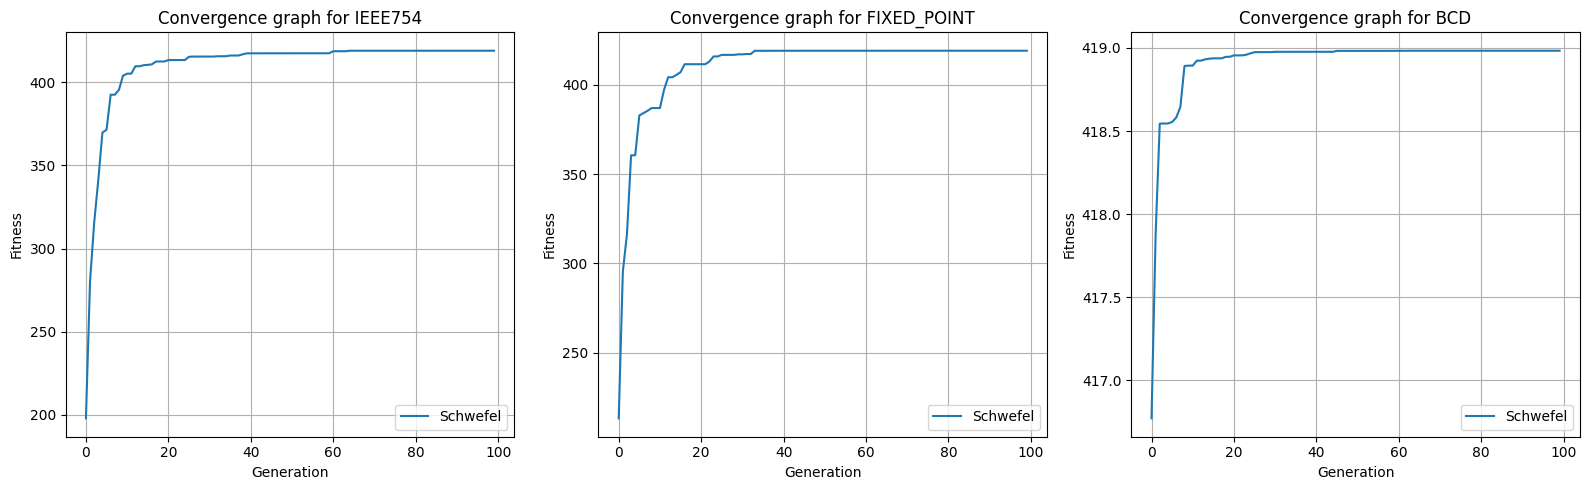

In [11]:
run_test(schwefel_population, 100, schwefel, "Schwefel", [-500.0, 500.0])

# Sphere
Zde jsme testovali algoritmus na funkci Sphere. Ta musela být invertována, protože se jedná o minimalizační problém a genetický algoritmus řeší maximalizační problémy. Interpretace IEEE754 a BCD si vedly podobně a mnohem lépe než reprezentace v Fixed Point, která se v rozsahu 50 generací nedokazála přiblížit.

Func: Sphere [IEEE754] ==> Worst: -10000.000000, Best: -0.000000, Mean: -1597.183117, Median: -0.918848, Std Dev: 3271.560596
Func: Sphere [FIXED_POINT] ==> Worst: -10000.000000, Best: -1.700397, Mean: -7012.391750, Median: -9364.478564, Std Dev: 3981.196715
Func: Sphere [BCD] ==> Worst: -10000.000000, Best: 0.000000, Mean: -6078.937255, Median: -8040.040323, Std Dev: 4651.048462


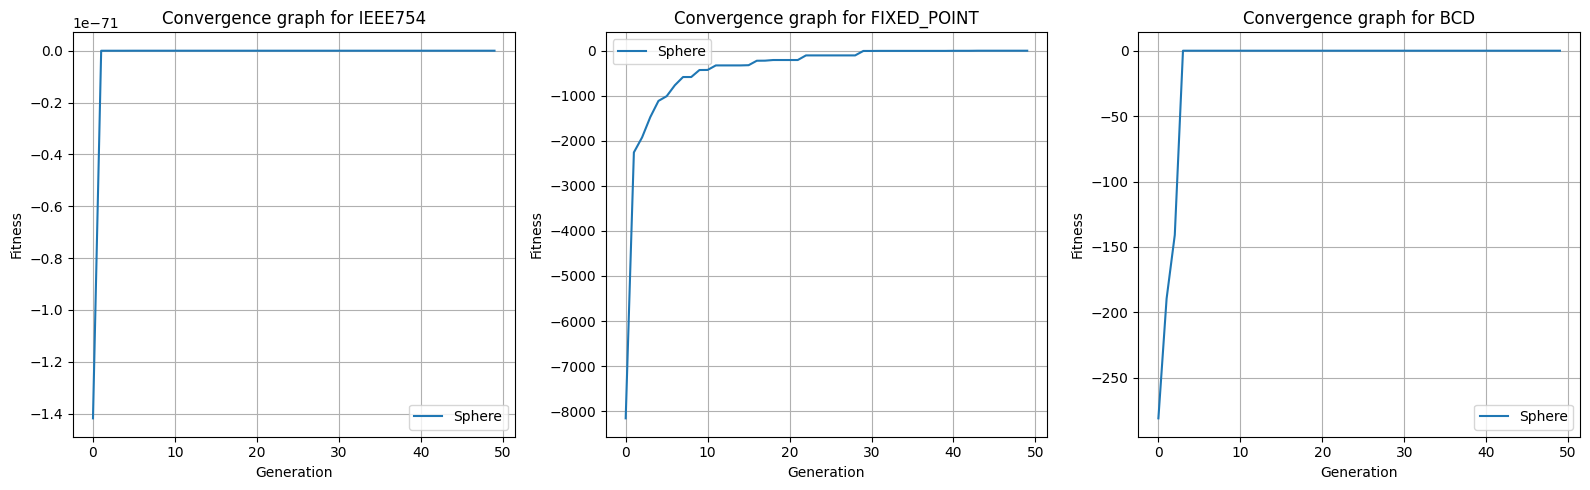

In [14]:
run_test(sphere_population, 50, sphere, "Sphere", [-100.0, 100.0])

# Rosenbrock
Populace, která použila reprezentaci IEEE754, dosáhla nejhorších výsledků. To bylo pravděpodobně způsobeno tím, že tato reprezentace reálných čísel je velmi citlivá na změny v jednotlivých bitech, a proto se nemohla přiblížit globálnímu minimu tak jako Fixed Point a BCD. Ostatní dvě interpretace si vedly obdobně a výrazně lépe než zmiňovaná IEEE754. Stejně jako v minulém příkladu byla i zde funkce převedena na maximalizační problém.

Func: Rosenbrock [IEEE754] ==> Worst: -1210121.000000, Best: -0.201318, Mean: -179232.633037, Median: -1.272755, Std Dev: 337499.387698
Func: Rosenbrock [FIXED_POINT] ==> Worst: -1210121.000000, Best: 0.000000, Mean: -656877.265501, Median: -810081.000000, Std Dev: 416680.103524
Func: Rosenbrock [BCD] ==> Worst: -1210121.000000, Best: 0.000000, Mean: -678477.313987, Median: -810081.000000, Std Dev: 419268.709439


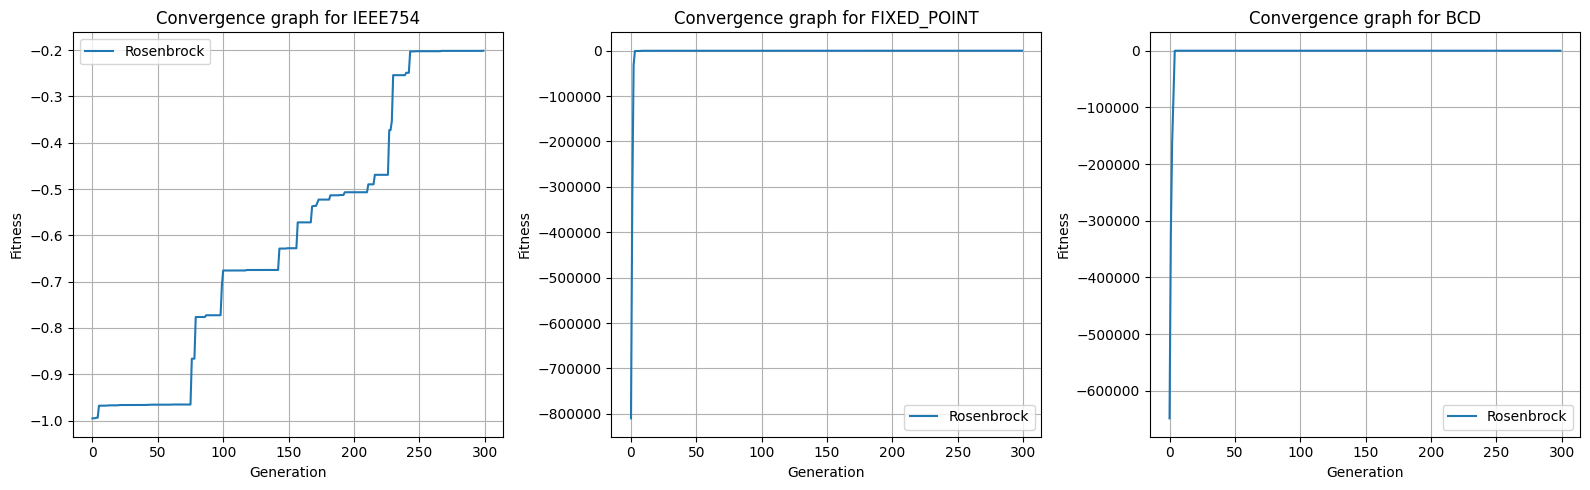

In [13]:
run_test(rosenbrock_population, 300, rosenbrock, "Rosenbrock", [-10.0, 10.0])

# Závěr

Ze všech grafů je patrné, že globálně si nejlépe vedla populace, která používala BCD reprezentaci reálných čísel, protože BCD reprezentace umožňuje přesné nastavení každé číslice v reálném čísle. V našem případě byl rozsah čísel (kladne i zaporné, 3 číslice v celočíselné části a 5 číslic v desetinné části). To pro tyto problémy byl dostatečným rozsahem i přesnost. Tato interpretace také není tak moc citlivá na změnu bitů, jako je tomu například v případě IEEE754, který u poslední "Rosenbrockovy" funkce selhal. Také Fixed Point dosáhla dobrých výsledků, ale přesto nepřekonal BCD, který jako jediný ve všech případech dosahl globálního extrému. 